# Introduction
We will attempt to predict the survivors from the Titanic sinkage. We will first clean and visualize our dataset before feeding it into a feed foward neural network to make predictions. We will also use popular Python libraries such as Pandas(data manipulation),  Matplotlib(data visualization) along with NumPy and Keras(numerical computation.)

In [1]:
# import dependacies
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
%matplotlib inline
print('numpy_version:', np.__version__)
print('pandas_version:', pd.__version__)
print('matplotlib_version:', matplotlib.__version__)
print('sklearn_version:', sklearn.__version__)
print('keras_version:', keras.__version__)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


numpy_version: 1.14.2
pandas_version: 0.22.0
matplotlib_version: 2.1.0
sklearn_version: 0.19.1
keras_version: 2.1.5



# EDA (Exploratory Data Analysis)
Import data and examine which features we must extract for our Neural Network(NN) and gain some insights into the data by visualizing it.
### Explore dataset

In [2]:
train_data_df = pd.read_csv('../input/train.csv')
print(train_data_df.columns)
print('DataFrame dimensions = ', train_data_df.shape)
train_data_df.head(10)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
DataFrame dimensions =  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
# we'll be using features: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked for our analysis. 
dropped_columns = ['Name', 'Ticket', 'Cabin']
train_data_df.drop(columns=dropped_columns, axis=1, inplace=True)

# Where columns where data is null/not there
print('ARE THERE ANY NULL DATA IN THESE COLUMNS')
print(train_data_df.isna().any())
print('\nAge has %d null values' % train_data_df.Age.isna().sum())
print('Embarked has %d null values' % train_data_df.Embarked.isna().sum())

ARE THERE ANY NULL DATA IN THESE COLUMNS
PassengerId    False
Survived       False
Pclass         False
Sex            False
Age             True
SibSp          False
Parch          False
Fare           False
Embarked        True
dtype: bool

Age has 177 null values
Embarked has 2 null values


In [4]:
# helper function for graphical representation
labels = ['Survived', 'Drowned']
colors = ['yellowgreen', '#ec4760']

def display_pie(titles, labels, i, c, n):
    # i = [survived, total]
    i = [[i0[0], i0[1]-i0[0]] for i0 in i] # i = [survived, total-survived] 
    
    fig, ax = plt.subplots(1,n)
    fig.set_size_inches(13, 5)
    for ax0 in ax:
        ax0.pie(i[0], labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
        ax0.set_title(titles[0])
        ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.show()

### Analyzing survivors based on gender

The ratio of males to females on the ship is 577 : 314


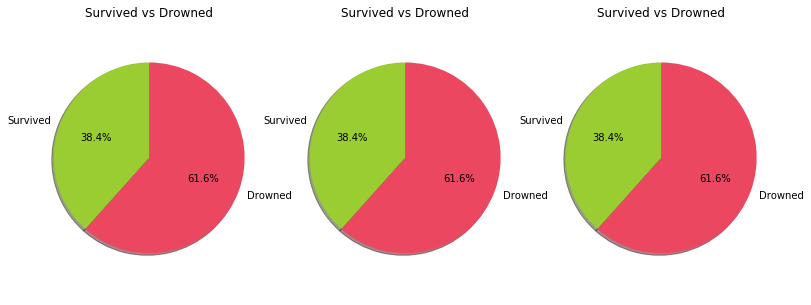

In [5]:
def plot_pie_survivors_gender():
    pie_survived = [train_data_df.Survived.sum(), train_data_df.Survived.count()]
    pie_male_survived = [train_data_df[(train_data_df.Sex == 'male') & (train_data_df.Survived == 1)].Sex.count(),
                        train_data_df[train_data_df.Sex == 'male'].Sex.count()]
    pie_female_survived = [train_data_df[(train_data_df.Sex == 'female') & (train_data_df.Survived == 1)].Sex.count(),
                        train_data_df[train_data_df.Sex == 'female'].Sex.count()]

    print('The ratio of males to females on the ship is %d : %d' % (pie_male_survived[1], pie_female_survived[1]))

    display_pie(['Survived vs Drowned', 'Survived vs Drowned (Male)', 'Survived vs Drowned (Female)'],
               labels, [pie_survived, pie_male_survived, pie_female_survived], colors, 3)


plot_pie_survivors_gender()

From the visualization we can see that almost **three-quarters of the passengers lost their lives** in the sinking of the Titanic. Additionally, the **percentage of survival for a female traveller was almost three times as much a male traveller** eventhough there were almost **twice as many males as females travelling** in the ship.

### Analyzing survivors based on the class they were travelling in and the fare they paid

class 	 number of travellers 	 number of survivals 	 chances of survival(%)
1 	 216 			 136 			 62.96
2 	 184 			 87 			 47.28
3 	 491 			 119 			 24.24


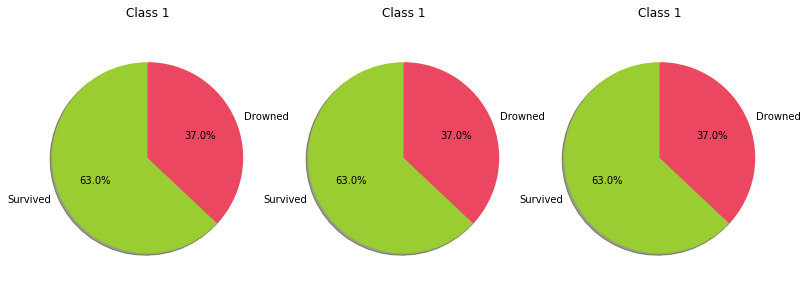

In [6]:
def plot_pie_survivors_class():
    pie_class_1 = [train_data_df[(train_data_df.Pclass == 1) & (train_data_df.Survived == 1)].Pclass.count(),
        train_data_df[train_data_df.Pclass == 1].Pclass.count()]
    pie_class_2 = [train_data_df[(train_data_df.Pclass == 2) & (train_data_df.Survived == 1)].Pclass.count(),
        train_data_df[train_data_df.Pclass == 2].Pclass.count()]
    pie_class_3 = [train_data_df[(train_data_df.Pclass == 3) & (train_data_df.Survived == 1)].Pclass.count(),
        train_data_df[train_data_df.Pclass == 3].Pclass.count()]

    print('class \t number of travellers \t number of survivals \t chances of survival(%)')
    print('%d \t %d \t\t\t %d \t\t\t %.2f' % (1, pie_class_1[1], pie_class_1[0], pie_class_1[0]/pie_class_1[1]*100))
    print('%d \t %d \t\t\t %d \t\t\t %.2f' % (2, pie_class_2[1], pie_class_2[0], pie_class_2[0]/pie_class_2[1]*100))
    print('%d \t %d \t\t\t %d \t\t\t %.2f' % (3, pie_class_3[1], pie_class_3[0], pie_class_3[0]/pie_class_3[1]*100))

    display_pie(['Class 1', 'Class 2', 'Class 3'], labels, [pie_class_1, pie_class_2, pie_class_3], colors, 3)

    
plot_pie_survivors_class()

 From observing the pie charts, we can see that **a passenger's chances of survival depended a lot on the class they were travelling in**. The **survival rate of passengers travelling in class 1 was double than that of class 3**. We can see the **death-rate increase through class 1-3**.

### Age Analysis

In [7]:
train_data_df.Age.dropna().describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

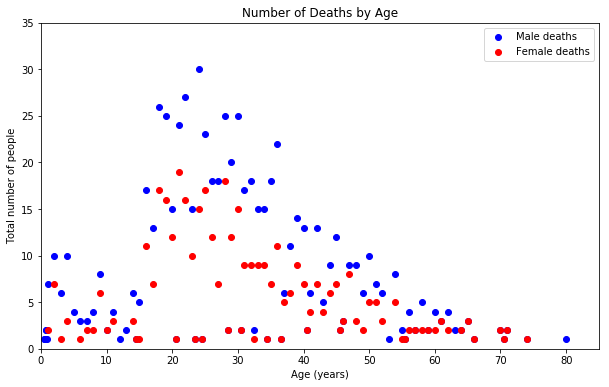

In [8]:
def plot_scatter_deaths_age():
    t_X = train_data_df.Age.value_counts().index.tolist()
    t_Y = train_data_df.Age.value_counts()
    t_Z = np.polyfit(t_X, t_Y, 2)
    t_P = np.poly1d(t_Z)

    s_X = train_data_df.Age[train_data_df.Survived == 0].value_counts().index.tolist()
    s_Y = train_data_df.Age[train_data_df.Survived == 0].value_counts()
    s_Z = np.polyfit(s_X, s_Y, 2)
    s_P = np.poly1d(s_Z)

    xp = np.linspace(0, 100, 100)
    plt.ylim(0,35)
    plt.xlim(0,train_data_df.Age.max()+5)
    plt.xlabel('Age (years)')
    plt.ylabel('Total number of people')
    plt.title('Number of Deaths by Age')

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(10, 6)

    plt.scatter(x=t_X, y=t_Y, c='blue')
    plt.scatter(x=s_X, y=s_Y, c='red')
    plt.legend(('Male deaths','Female deaths'))
    plt.show()


plot_scatter_deaths_age()

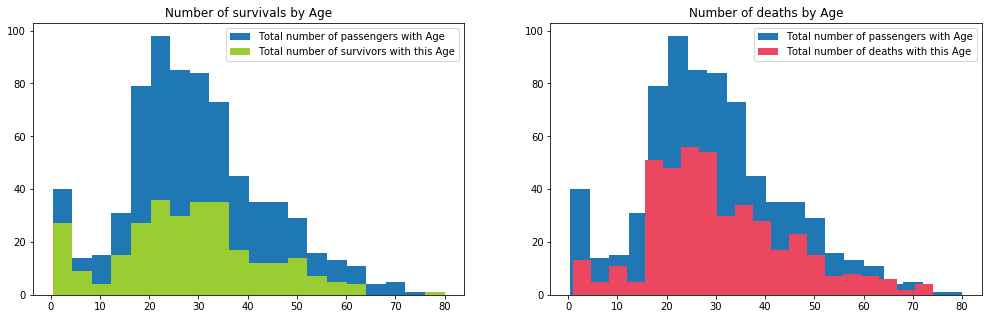

In [9]:
def plot_hist_deaths_age():
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(17, 5)

    number_of_bins = 20
    ax1.hist(train_data_df.Age.dropna().values, bins=number_of_bins)
    ax1.hist(train_data_df[train_data_df.Survived==1].Age.dropna().values, bins=number_of_bins, color=colors[0])
    ax1.set_title('Number of survivals by Age')
    ax1.legend(labels=['Total number of passengers with Age', 'Total number of survivors with this Age'])

    ax2.hist(train_data_df.Age.dropna().values, bins=number_of_bins)
    ax2.hist(train_data_df[train_data_df.Survived==0].Age.dropna().values, bins=number_of_bins, color=colors[1])
    ax2.set_title('Number of deaths by Age')
    ax2.legend(labels=['Total number of passengers with Age', 'Total number of deaths with this Age'])

    plt.show()


plot_hist_deaths_age()

By analysing the abovev graphs, we can conclude two things:
1. Females had more chances of survival than males.
2. Passengers between the ages of 20 and 50 had a lot less less chance of survival than others.

# Data Wrangling
Fix missing Age data

In [10]:
print('Total number of passengers:', train_data_df.shape[0])
print('Total number of passengers who haven their age is missing:', train_data_df.Age.isna().sum())

Total number of passengers: 891
Total number of passengers who haven their age is missing: 177


In [11]:
print(train_data_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')


In [12]:
train_data_df.Sex = train_data_df.Sex.apply(lambda x: 0 if x == 'female' else 1)
age_nn_df = train_data_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
age_nn_df = age_nn_df.dropna()
age_nn_df.Age = age_nn_df.Age.apply(lambda x: x/100.0)
age_train_df, age_test_df = train_test_split(age_nn_df, test_size=0.3)
print('Train data size: %s\nTest data size: %s' % (age_train_df.shape[0], age_test_df.shape[0]))

Train data size: 499
Test data size: 215


### Build neural network

In [13]:
age_net_filepath = 'age_net-weights-{epoch:02d}.hdf5'
age_net_checkpoint = keras.callbacks.ModelCheckpoint(
    age_net_filepath, monitor='val_acc', save_weights_only=False,
    save_best_only=False, mode='max', verbose=0
)

In [14]:
X = age_train_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].values
Y = age_train_df[['Age']].values
print(X[:5])
print(Y[:5])

[[ 1.      0.      0.      0.     78.85  ]
 [ 3.      0.      0.      0.      7.7333]
 [ 3.      1.      0.      0.     56.4958]
 [ 2.      1.      1.      1.     36.75  ]
 [ 3.      1.      0.      0.      7.8958]]
[[0.26]
 [0.16]
 [0.26]
 [0.19]
 [0.28]]


In [15]:
age_net = Sequential()

def train_age_nn():    
    age_net.add(Dense(5, input_dim=5, activation='relu'))
    age_net.add(Dense(10, activation='relu'))
    age_net.add(Dense(5, activation='relu'))
    age_net.add(Dense(5, activation='relu'))
    age_net.add(Dense(3, activation='relu'))
    age_net.add(Dense(1, activation='linear'))

    age_net.compile(
        optimizer='adam',
        loss='mse'
    )

    age_net.fit(X, Y, epochs=60, batch_size=60, callbacks=[age_net_checkpoint], initial_epoch=0, verbose=0)
    
    
train_age_nn()

In [16]:
def test_age_nn():
    X = age_test_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].values
    Y = age_test_df[['Age']].values

    preds = (age_net.predict(X)*100)
    count = 0
    for pred, acc in zip(preds, Y):
        pred, acc = int(pred), int(acc[0]*100)
        if not(0 < abs(pred-acc) < 15):
            count += 1
    print('Accuracy of our age model: {:.2f}% '.format((X.shape[0]-count)/X.shape[0]*100))
    

test_age_nn()

Accuracy of our age model: 67.91% 


In [17]:
temp = np.random.randint(0, 100)
X = train_data_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].loc[temp].values
Y = train_data_df[['Age']].loc[temp].values
X = np.transpose([X]).T
temp_prediction = age_net.predict(X)
print('Predicted: %.2f \nActual: %.2f' % (Y[0], temp_prediction[0][0]*100))

Predicted: 3.00 
Actual: 29.38


 ### Use the age model we trained to make predictions

In [18]:
print(train_data_df.isna().any())
train_data_df.head()

PassengerId    False
Survived       False
Pclass         False
Sex            False
Age             True
SibSp          False
Parch          False
Fare           False
Embarked        True
dtype: bool


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,0,38.0,1,0,71.2833,C
2,3,1,3,0,26.0,0,0,7.9250,S
3,4,1,1,0,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S


In [19]:
train_data_df['AgeAdjusted'] = pd.Series()

def predict_missing_passengers_ages():
    age_col = []
    age_adjusted = []
    for index, row in train_data_df.iterrows():
        if math.isnan(row.Age):
            X = train_data_df.loc[index][['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].values
            X = np.transpose([X]).T
            age_prediction = int(age_net.predict(X) * 100)
            age_col.append(age_prediction)
            age_adjusted.append(1)
        else:
            age_col.append(row.Age)
            age_adjusted.append(0)
    
    train_data_df.Age = age_col
    train_data_df.AgeAdjusted = age_adjusted


predict_missing_passengers_ages()

In [20]:
train_data_df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeAdjusted
0,1,0,3,1,22.0,1,0,7.2500,S,0
1,2,1,1,0,38.0,1,0,71.2833,C,0
2,3,1,3,0,26.0,0,0,7.9250,S,0
3,4,1,1,0,35.0,1,0,53.1000,S,0
4,5,0,3,1,35.0,0,0,8.0500,S,0
5,6,0,3,1,29.0,0,0,8.4583,Q,1
6,7,0,1,1,54.0,0,0,51.8625,S,0
7,8,0,3,1,2.0,3,1,21.0750,S,0
8,9,1,3,0,27.0,0,2,11.1333,S,0
9,10,1,2,0,14.0,1,0,30.0708,C,0


 ### Train model to predict passenger survival!

In [21]:
survive_train_df, survive_test_df = train_test_split(train_data_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']], test_size=.1)
print('survive_net_train size:', survive_train_df.shape[0])
survive_train_df.head()

survive_net_train size: 801


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
467,1,1,56.0,0,0,26.5500,0
503,3,0,37.0,0,0,9.5875,0
36,3,1,29.0,0,0,7.2292,1
404,3,0,20.0,0,0,8.6625,0
296,3,1,23.5,0,0,7.2292,0


In [22]:
X = survive_train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
Y = survive_train_df['Survived']

print(X[:5])
print(Y[:5])

     Pclass  Sex   Age  SibSp  Parch     Fare
467       1    1  56.0      0      0  26.5500
503       3    0  37.0      0      0   9.5875
36        3    1  29.0      0      0   7.2292
404       3    0  20.0      0      0   8.6625
296       3    1  23.5      0      0   7.2292
467    0
503    0
36     1
404    0
296    0
Name: Survived, dtype: int64


### Build and train neural network

In [23]:
survive_net = Sequential()

def train_survive_nn():
    survive_net.add(Dense(6, input_dim=6, activation='relu'))
    survive_net.add(Dense(12, activation='relu'))
    survive_net.add(Dense(6, activation='relu'))# kernel_initializer='normal'))    
    survive_net.add(Dense(12, activation='relu'))# kernel_initializer='normal'))
    survive_net.add(Dense(6, activation='relu'))# kernel_initializer='normal'))
    survive_net.add(Dense(1, activation='sigmoid'))

    survive_net.compile(
        optimizer='adam',
        loss='mse',
    )

    survive_net.fit(X, Y, epochs=60, batch_size=60, verbose=0)    
    
train_survive_nn()

In [24]:
def temp_test_survive_nn():
    X, Y = survive_test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values, survive_test_df[['Survived']].values
    
    preds = survive_net.predict(X)
    count = 0
    
    for pred, acc in zip(preds, Y):
        pred = np.round(pred)
        if pred[0] != acc[0]:
            count +=1
    print('Accuracy of our age model: {:.2f}% '.format((X.shape[0]-count)/X.shape[0]*100))


temp_test_survive_nn()

Accuracy of our age model: 80.00% 


In [25]:
# let's train it on the entire train dataset
X, Y = train_data_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']], train_data_df[['Survived']]
train_survive_nn()

### Examine the testing data that we'll be using

In [26]:
test_data_df = pd.read_csv('../input/test.csv')
print(test_data_df.shape)
test_data_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [27]:
test_data_df.Sex = test_data_df.Sex.apply(lambda x: 0 if x == 'female' else 1)

test_data_df = test_data_df.drop(['Name', 'Cabin','Ticket', 'Embarked'], axis=1)
print(test_data_df.isna().any())
print('Fare has %d entries missing' % test_data_df.Fare.isna().sum())
print('Age has %d entries missing' % test_data_df.Age.isna().sum())
test_data_df.head()

PassengerId    False
Pclass         False
Sex            False
Age             True
SibSp          False
Parch          False
Fare            True
dtype: bool
Fare has 1 entries missing
Age has 86 entries missing


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


In [28]:
removePassId = test_data_df[test_data_df.Fare.isna()].PassengerId.values[0]
test_data_df = test_data_df[test_data_df.PassengerId != removePassId]
test_data_df.shape

(417, 7)

In [29]:
test_output_df = pd.read_csv('../input/gender_submission.csv')
print(test_output_df.shape)
test_output_df.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [30]:
test_output_df = test_output_df[test_output_df.PassengerId != removePassId]
test_output_df.shape

(417, 2)

### Use our age network
Our age net takes data in the form ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']

In [31]:
def fill_missing_age_values_testdf():
    age_vals = []
    for index, row in test_data_df.iterrows():
            if math.isnan(row.Age):
                X = test_data_df.loc[index][['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']].values
                X = np.transpose([X]).T
                age_prediction = int(age_net.predict(X) * 100)
                age_vals.append(age_prediction)
            else:
                age_vals.append(row.Age)
                
    test_data_df.Age = age_vals
                
    
fill_missing_age_values_testdf()

In [32]:
test_data_df.Age.isna().sum()

0

In [33]:
def test_survive_net():
    X = test_data_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
    Y = test_output_df['Survived']
    
    preds = survive_net.predict(X)
    preds = np.round(preds)
    
    count = 0
    for pred, acc in zip(preds, Y):
        if np.round(pred) != acc:
            count += 1
    
    total_rows = X.shape[0]
    print('Our model predicted %d out of %d' % (total_rows-count, total_rows))
    print('Final accuracy: {:.2f}%'.format((total_rows-count)/total_rows*100))
    

test_survive_net()

Our model predicted 365 out of 417
Final accuracy: 87.53%
